# Phase 1: Data Loading & Analysis (The "Sanity Check")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
# Ensure 'cust_data.csv' is uploaded to your Colab files first!
try:
    df = pd.read_csv('/content/cust_data.csv')
    print("✅ Data Loaded Successfully!")
except FileNotFoundError:
    print("❌ Error: Please upload 'cust_data.csv' to the Colab files tab on the left.")

# 2. Quick Look
print(f"\nDataset Shape: {df.shape}")
print("\nFirst 5 Rows:")
display(df.head())

# 3. Check for Nulls & Duplicates
print("\nMissing Values:")
print(df.isnull().sum())
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# 4. Check Data Types
print("\nData Types:")
print(df.dtypes)

✅ Data Loaded Successfully!

Dataset Shape: (10000, 14)

First 5 Rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Duplicate Rows: 0

Data Types:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object


## Step 1.2: EDA (Visualization)

/tmp/ipython-input-2027808666.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Exited', data=df, palette='coolwarm')


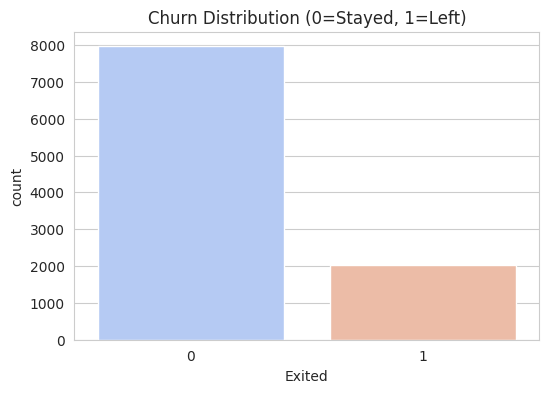

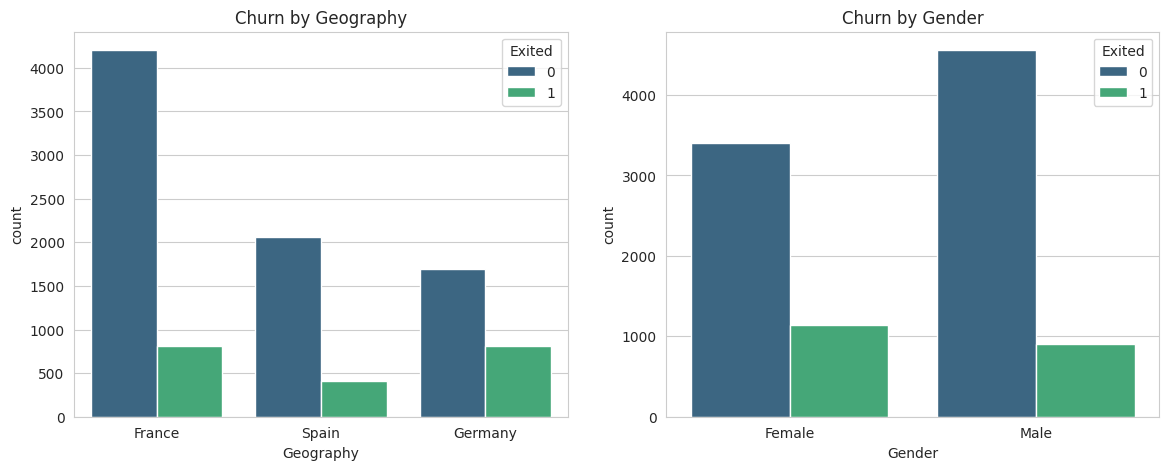

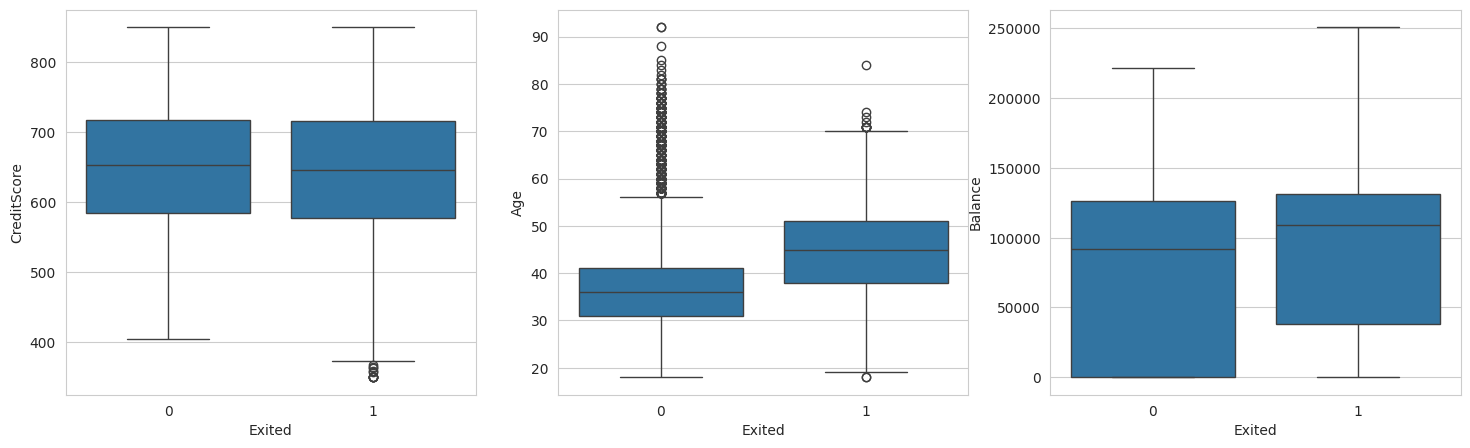

In [2]:
# Set visual style
sns.set_style("whitegrid")

# 1. Churn Distribution (Is the dataset balanced?)
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=df, palette='coolwarm')
plt.title("Churn Distribution (0=Stayed, 1=Left)")
plt.show()

# 2. Categorical Features vs Churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Geography
sns.countplot(x='Geography', hue='Exited', data=df, ax=axes[0], palette='viridis')
axes[0].set_title("Churn by Geography")

# Gender
sns.countplot(x='Gender', hue='Exited', data=df, ax=axes[1], palette='viridis')
axes[1].set_title("Churn by Gender")

plt.show()

# 3. Numerical Features (Boxplots to spot outliers)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Exited', y='CreditScore', data=df, ax=axes[0])
sns.boxplot(x='Exited', y='Age', data=df, ax=axes[1])
sns.boxplot(x='Exited', y='Balance', data=df, ax=axes[2])
plt.show()

 # Phase 2: Preprocessing (The "Deep Learning Prep")

## Step 2.1: Clean & Encode

In [3]:
# 1. Drop Useless Columns
# RowNumber, CustomerId, and Surname do not cause Churn. They are noise.
df_clean = df.drop(columns=['RowNumber', 'CustomerId', 'Surname'])

# 2. One-Hot Encoding
# Turns "Geography" (France, Spain, Germany) into 3 columns of 0s and 1s.
# drop_first=True helps avoid multicollinearity (Deep Learning is usually robust to this, but it's good practice).
df_encoded = pd.get_dummies(df_clean, columns=['Geography', 'Gender'], drop_first=True)

print("New Columns after Encoding:")
print(df_encoded.columns.tolist())

New Columns after Encoding:
['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


## Step 2.2: Split & Scale (CRITICAL)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

# 1. Define Features (X) and Target (y)
X = df_encoded.drop(columns=['Exited'])
y = df_encoded['Exited'].values

# 2. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Scale Data
# Neural Networks learn weights. If "Balance" is 50,000 and "Age" is 30, the network will think Balance is more important.
# Scaling makes them all "equal" (roughly between -1 and 1).
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Save the Scaler immediately (So we don't forget!)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✅ Scaler saved as 'scaler.pkl'")
print(f"Training Shape: {X_train_scaled.shape}")
print(f"Testing Shape: {X_test_scaled.shape}")

✅ Scaler saved as 'scaler.pkl'
Training Shape: (8000, 11)
Testing Shape: (2000, 11)


# Phase 3: Building & Training

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 1. Initialize the Neural Network
model = Sequential()

# 2. Add Layers
# Input Layer: 11 neurons (matches our 11 features), Activation='relu'
model.add(Dense(units=16, activation='relu', input_dim=11))

# Hidden Layer: 8 neurons (helps capture patterns), Activation='relu'
model.add(Dense(units=8, activation='relu'))

# Output Layer: 1 neuron (Binary classification), Activation='sigmoid'
# Sigmoid forces the result to be between 0 and 1 (Probability)
model.add(Dense(units=1, activation='sigmoid'))

# 3. Compile the Model
# Optimizer: Adam (The best general-purpose optimizer)
# Loss: Binary Crossentropy (Standard for Yes/No problems)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train the Model
print("🚀 Training Started...")
# We use 'history' to save the training logs for plotting later
# epochs=100: It will go through the data 100 times
# batch_size=32: It learns from 32 customers at a time
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    batch_size=32,
                    epochs=100,
                    verbose=1)

print("\n✅ Training Complete!")

🚀 Training Started...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5218 - loss: 0.6952 - val_accuracy: 0.8120 - val_loss: 0.4716
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8047 - loss: 0.4568 - val_accuracy: 0.8220 - val_loss: 0.4085
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8215 - loss: 0.4126 - val_accuracy: 0.8415 - val_loss: 0.3826
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8418 - loss: 0.3851 - val_accuracy: 0.8540 - val_loss: 0.3648
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8512 - loss: 0.3688 - val_accuracy: 0.8515 - val_loss: 0.3543
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8555 - loss: 0.3589 - val_accuracy: 0.8545 - val_loss: 0.3476
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8567 - loss: 0.3491 - val_accuracy: 0.8550 - val_loss: 0.3456
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8573 - loss: 0.3463 - val_accuracy: 0.8605

# Phase 4: Evaluation & Saving (The Finish Line)

## Step 4.1: Visualize Accuracy & Loss

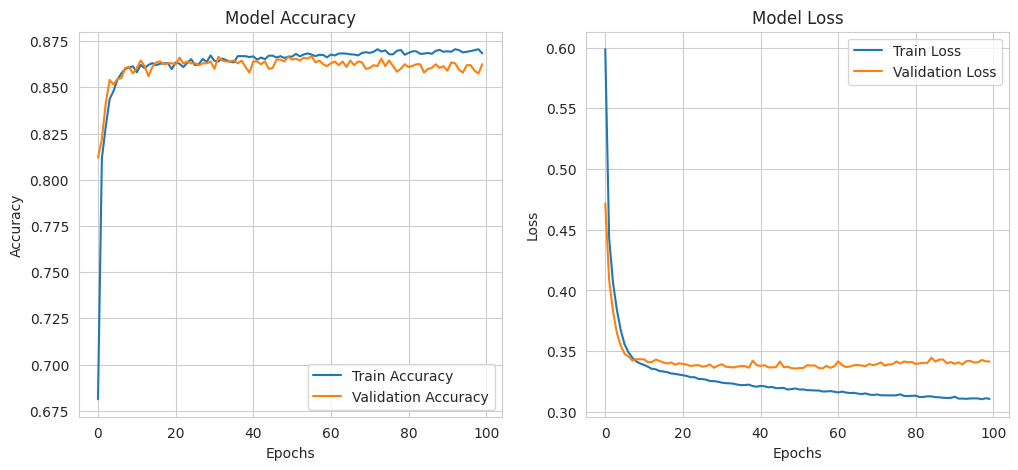

In [6]:
import matplotlib.pyplot as plt

# Plot Training vs Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 4.5: The "Pro" Training Run

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight

# 1. Calculate Class Weights (The "Secret Sauce")
# This forces the AI to pay attention to the minority class (Churners)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = dict(enumerate(class_weights))
print(f"⚖️ Class Weights: {weights_dict}")
# (Likely Class 0 will be ~0.6 and Class 1 will be ~2.5)

# 2. Build the "Pro" Architecture
model = Sequential()

# Input Layer: Increased to 64 neurons + BatchNormalization (Stabilizes learning)
model.add(Dense(64, activation='relu', input_dim=11))
model.add(BatchNormalization())
model.add(Dropout(0.2)) # Prevents overfitting (20% of neurons turn off randomly)

# Hidden Layer 1: 32 neurons
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden Layer 2: 16 neurons
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# 3. Compile with Custom Learning Rate
# We start slightly faster, then slow down
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 4. Define Callbacks (Smart Training)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# 5. Train with Weights & Callbacks
print("🚀 Training Tuned Model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    epochs=150,           # We set high epochs, but EarlyStopping will stop it automatically
    class_weight=weights_dict, # Applying the balance fix
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✅ Tuning Complete!")

⚖️ Class Weights: {0: np.float64(0.6293266205160478), 1: np.float64(2.4330900243309004)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


🚀 Training Tuned Model...
Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5757 - loss: 0.7303 - val_accuracy: 0.6895 - val_loss: 0.6158 - learning_rate: 0.0010
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6793 - loss: 0.5916 - val_accuracy: 0.7465 - val_loss: 0.5263 - learning_rate: 0.0010
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7287 - loss: 0.5307 - val_accuracy: 0.7610 - val_loss: 0.5019 - learning_rate: 0.0010
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7272 - loss: 0.5453 - val_accuracy: 0.7715 - val_loss: 0.4914 - learning_rate: 0.0010
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7567 - loss: 0.5088 - val_accuracy: 0.7825 - val_loss: 0.4772 - learning_rate: 0.0010
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7646 - loss: 0.5066 - val_accuracy: 0.7740 - val_loss: 0.4784 - learning_rate: 0.0010
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - a

In [8]:
from sklearn.metrics import classification_report

# Predict Probabilities
y_pred_prob = model.predict(X_test_scaled)
# Convert to Class (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1607
           1       0.51      0.75      0.61       393

    accuracy                           0.81      2000
   macro avg       0.72      0.79      0.74      2000
weighted avg       0.85      0.81      0.82      2000



# Hypertuning

## Step 1: Install Keras Tuner

In [9]:
!pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.2 MB/s eta 0:00:00


## Step 2: The "Hypermodel" Search

In [10]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# 1. Define the Model-Building Function
def build_model(hp):
    model = Sequential()

    # Tuner: Try different numbers of neurons in the first layer (32 to 128)
    hp_units1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_units1, activation='relu', input_dim=11))
    model.add(BatchNormalization())

    # Tuner: Try different dropout rates (0.1 to 0.4)
    hp_dropout = hp.Float('dropout_1', min_value=0.1, max_value=0.4, step=0.1)
    model.add(Dropout(hp_dropout))

    # Tuner: Decide if we want a second hidden layer or not
    if hp.Boolean('use_second_layer'):
        hp_units2 = hp.Int('units_2', min_value=16, max_value=64, step=16)
        model.add(Dense(units=hp_units2, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp_dropout))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Tuner: Try different Learning Rates
    hp_lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# 2. Setup the Tuner (Using Hyperband algorithm - it's fast and smart)
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='my_dir',
    project_name='churn_tuning'
)

# 3. Stop early if it's not learning
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# 4. Run the Search! (This might take 5-10 mins)
print("🚀 Starting Hyperparameter Search...")
tuner.search(X_train_scaled, y_train,
             epochs=50,
             validation_split=0.2,
             callbacks=[stop_early],
             class_weight=weights_dict) # Keep using our class weights!

# 5. Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
✅ Tuning Complete!
The optimal number of units in the first layer is {best_hps.get('units_1')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
Use second layer? {best_hps.get('use_second_layer')}.
""")

Trial 90 Complete [00h 00m 13s]
val_accuracy: 0.7943750023841858

Best val_accuracy So Far: 0.8306249976158142
Total elapsed time: 00h 12m 50s

✅ Tuning Complete!
The optimal number of units in the first layer is 128.
The optimal learning rate is 0.01.
Use second layer? False.



# Phase 5: Final Training & Evaluation

## Step 5.1: Train the "Winner" Model

🚀 Training Final Model...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6720 - loss: 0.6582 - val_accuracy: 0.7535 - val_loss: 0.5048
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7463 - loss: 0.5260 - val_accuracy: 0.7660 - val_loss: 0.5094
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7556 - loss: 0.5237 - val_accuracy: 0.8070 - val_loss: 0.4311
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7644 - loss: 0.5074 - val_accuracy: 0.7600 - val_loss: 0.4819
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7668 - loss: 0.5032 - val_accuracy: 0.7315 - val_loss: 0.5173
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7604 - loss: 0.4985 - val_accuracy: 0.7550 - val_loss: 0.5115
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7647 - loss: 0.4968 - val_accuracy: 0.8090 - val_loss: 0.4393
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7668 - loss:

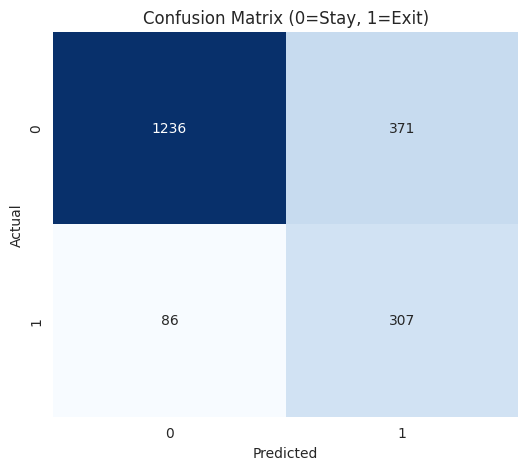

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Build the Winner Architecture (Based on your Tuning results)
final_model = Sequential()

# Layer 1: 128 Neurons (The optimal number found)
final_model.add(Dense(128, activation='relu', input_dim=11))
final_model.add(BatchNormalization())
final_model.add(Dropout(0.3)) # Increased dropout slightly to prevent overfitting on the large layer

# Output Layer
final_model.add(Dense(1, activation='sigmoid'))

# 2. Compile with Optimal Learning Rate (0.01)
optimizer = Adam(learning_rate=0.01)
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# 3. Train on the Full Training Set
print("🚀 Training Final Model...")
history_final = final_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    epochs=50, # 50 is usually enough for this size
    class_weight=weights_dict, # KEEP THIS! It handles the imbalanced classes
    verbose=1
)

# 4. Final Evaluation
print("\n--- 📊 Final Evaluation on Test Set ---")
loss, accuracy = final_model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# 5. Detailed Classification Report
y_pred_prob = final_model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n--- 📑 Classification Report ---")
print(classification_report(y_test, y_pred))

# 6. Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (0=Stay, 1=Exit)')
plt.show()

## Step 5.2: Save the "Gold Standard" Files

In [12]:
# Save the Final Model
final_model.save('churn_model.h5')

# Save the Scaler (Just in case you didn't save it in Phase 2)
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ SUCCESS! 'churn_model.h5' and 'scaler.pkl' are ready for download.")

✅ SUCCESS! 'churn_model.h5' and 'scaler.pkl' are ready for download.
